# Assignment 3 - Sentiment Analysis

Name: Melina Fartaj , 
Student ID: 1002348596

In [1]:
#importing all relevant and needed libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import re
from re import sub
import html
from html.parser import HTMLParser
import ast
from textblob import TextBlob
import string

from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
#filtering out the warning pop ups 
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyterlab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#pip install wordcloud

In [3]:
#pip install nltk

In [4]:
#pip install textblob

In [5]:
#pip install xgboost

## Q1 Data Cleaning 

As the tweets are not given in a form amenable to analysis (too much 'noise') the following steps will be taken to clean the data: 
- HTML tags will be replaced with ascci
- Tweet mentions will be removed 
- the 'RT' for retweets are removed
- URLs are removed
- Puncuation is removed 
- Tokenization (essentially splitting up the words)
- Stemming (getting words into their root forms) is applied to all tokens 
- All stop words are removed
- Manual removal of words if necessary

In [6]:
ps = SnowballStemmer('english')
def clean_text(text):
    #Replace HTML tag with ascci
    texthtml = html.unescape(text)
    
    # Remove mentions
    textm = re.sub(r'@[A-Za-z0-9_]+', '', texthtml)
    
    # Remove retweets:
    textr = re.sub(r'RT : ', '', textm)
    
    # Remove urls
    texturl = re.sub(r"https?://?\S+", '', textr)
    
    text_lc = "".join([word.lower() for word in texturl if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword] #removing stop words and conducting stemming
    return text

In [7]:
df2 = pd.read_csv('sentiment_analysis.csv',encoding="utf-8")
df2

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


In [8]:
#adding a sentiment column based on label column
df2['sentiment'] = df2['label'].apply(lambda x: 'positive' if x == 1 else 'negative')

#### Basic Feature Extraction of text

This step is done so i can get more general information about the data before cleaning. the following is calculated: 

- Number of words - the idea behind finding the number of words in each tweet is that the more words a tweet has the more likely it is to have a negative sentiment
- Number of characters - same idea as counting the number of words (note: includes spaces). Looking at character count can sometimes be better in text data such as tweets because a lot of words are put together for hashtags so even though it will show up as only 1 word in the word count the true length of the tweet is shown in counting the number of characters
- Counting all the stop words. Before removing all the stop words it is good to view how many stop words are being used in each tweet in case some extra insight can be given 
- Number of Hashtags used (special characters) 

In [9]:
#counting the number of characters in each tweet
df2['char_count'] = df2['text'].str.len()
#counting the number of words in each tweet
df2['word_count'] = df2['text'].apply(lambda x: len(str(x).split(" ")))

#counting the number of times stop words are present in each tweet
stop = stopwords.words('english')
df2['stopwords'] = df2['text'].apply(lambda x: len([x for x in x.split() if x in stop]))

 #counting the number of hashtags that are used in each tweet
df2['hashtags'] = df2['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

df2['label'] = df2['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [10]:
df2

,ID,text,label,sentiment,char_count,word_count,stopwords,hashtags
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,positive,114,13,2,0
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,positive,140,15,5,2
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,positive,140,20,6,0
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,positive,139,19,4,0
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,positive,130,18,6,0
...,...,...,...,...,...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0,negative,76,8,0,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0,negative,96,16,5,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1,positive,107,12,2,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,positive,130,13,2,1


array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

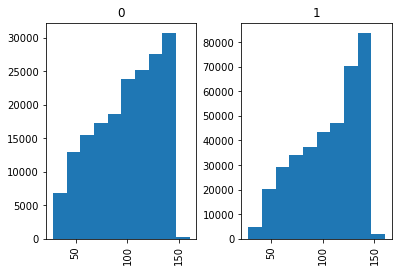

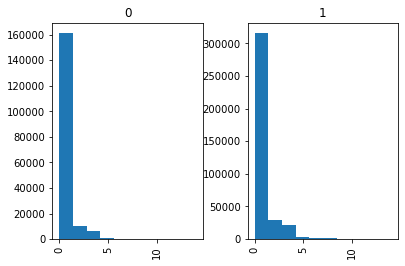

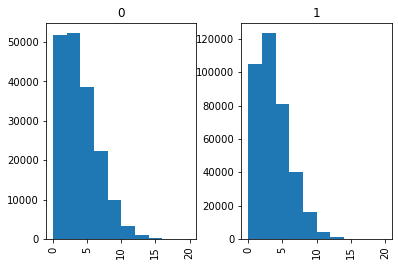

In [11]:
#plotting the distribution between the positive and negative tweets based on character count, hashtags and stop words
df2.hist('char_count',by='label') 
df2.hist('hashtags',by='label')
df2.hist('stopwords',by='label')

By looking at the distributions one can see that the distribution for negative and positive sentiment words are different. Once can notice that for all the categories the positive sentiment tweets are more. This makes sense as the data is not fully balanced (there are more positive sentiment tweets)

In [12]:
#replacing the dataframe back to its original form
df2 = df2[['text', 'label', 'sentiment']]

In [13]:
#applying the clean_text function
stopword = nltk.corpus.stopwords.words('english')
df2['clean_text'] = df2['text'].apply(clean_text)

In [14]:
df2

,text,label,sentiment,clean_text
0,Josh Jenkins is looking forward to TAB Breeder...,1,positive,"[josh, jenkin, look, forward, tab, breeder, cr..."
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1,positive,"[congratul, pakistan, becom, notestteam, world..."
2,"RT @PEPalerts: This September, @YESmag is taki...",1,positive,"[septemb, take, main, mendoza, surpris, thanks..."
3,"RT @david_gaibis: Newly painted walls, thanks ...",1,positive,"[newli, paint, wall, thank, million, custodi, ..."
4,RT @CedricFeschotte: Excited to announce: as o...,1,positive,"[excit, announc, juli, feschott, lab, reloc, m..."
...,...,...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0,negative,"[, cant, stop, watch, hermm, ]"
550387,Poor old Tom Odell doesn't look like he would ...,0,negative,"[poor, old, tom, odel, doesnt, look, like, wou..."
550388,#antsmasher I smashed 7 ants in this awesome ...,1,positive,"[antsmash, smash, ant, awesom, gamehjfjfi, ]"
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,positive,"[, morn, girl, wonder, friday, ]"


In [15]:
#function to convert to string to allow for easier manipulation as seen below
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

In [16]:
#converting to a string
df2['string'] = df2['clean_text'].apply(listToString)

In [17]:
#this option was used to view all the rows in freq2 so it is commented out because it was very long
#pd.set_option('display.max_rows', None)

In [18]:
#viewing the distribution of words
freq2 = pd.Series(' '.join(df2['string']).split()).value_counts()
freq2.head(20)

love         63856
happi        52480
thank        35767
great        29574
good         27944
day          26522
im           25760
best         25519
amaz         24915
birthday     24244
look         20214
get          19482
one          18140
beauti       17026
found        16639
like         16585
dont         15690
make         15274
today        14480
transpond    14206
dtype: int64

In [19]:
#testing out where a lot of the frequency drops
freq2[freq2<3000]

hard                  2958
two                   2949
local                 2931
w                     2885
that                  2848
                      ... 
stillplay                1
collaborationtechn       1
newtrend                 1
laxus                    1
tuesssdaaay              1
Length: 201053, dtype: int64

Since the cutoff frequency count at 3000 was 2958 which is 4.6% of the max which is 63856 i removed those words to limit run time and provide a cleaner dataset. Words with that low of frequencies are assumed to be not as much importance therefore this approach was taken. 

In [20]:
#removing words that have less than 3000 frequency
new_words = freq2[freq2<3000]
df2['clean_tweets'] = df2['string'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words))

In [21]:
#viewing how many words are still left 
freq3 = pd.Series(' '.join(df2['clean_tweets']).split()).value_counts()
freq3

love      63856
happi     52480
thank     35767
great     29574
good      27944
          ...  
black      3026
http       3017
must       3003
friday     3000
next       3000
Length: 186, dtype: int64

It appears that even though words less than 3000 frequency were only 4.6% of the max count, it removed 201053 words and left us with only 186 left. I noticed there were still some words that were not meaningful in the list so i manually looked down the list and removed words i deemed of no value as below: 

In [22]:
#to remove even more words i manually looked at the 186 words and removed words i thought were either irrelevent or did not have a meaning when by themselves
freq= ["im" ,"look" ,"today" ,"time" ,"u" ,"go" ,"rt" ,"know" ,"got" ,"come"  ,"thing" ,"even" ,"back" ,"alway" ,"your" ,"https" ,"let" ,"take" ,"tri" ,"via" ,"th" ,"would" ,"use" ,"find" ,"set" ,"could" ,"check" ,"ive" ,"lot" ,"oh" ,"tell" ,"ur" ,"yall" ,"person" ,"anoth" ,"http" ,"must" ,"next" ]
df2['done_tweets'] = df2['clean_tweets'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [23]:
#reviewing the final words that are left over after removal
freq4 = pd.Series(' '.join(df2['done_tweets']).split()).value_counts()
freq4

love         63856
happi        52480
thank        35767
great        29574
good         27944
             ...  
congrat       3115
favorit       3115
congratul     3111
black         3026
friday        3000
Length: 148, dtype: int64

#### Canadian Election Tweets

The same steps that were taken for the generic tweets above will be taken for the Canadian Election Tweets

In [24]:
df = pd.read_csv('Canadian_elections_2019.csv',encoding="utf-8")
df.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [25]:
#adding a label column based on sentiment
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [26]:
#counting the number of characters in each tweet
df['char_count'] = df['text'].str.len()
#counting the number of words in each tweet
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

#counting the number of times stop words are present in each tweet
stop = stopwords.words('english')
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))

 #counting the number of hashtags that are used in each tweet
df['hashtags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

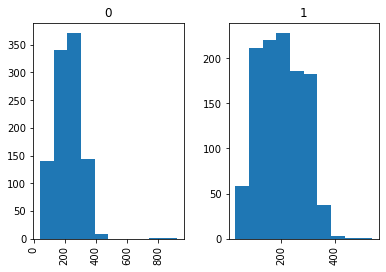

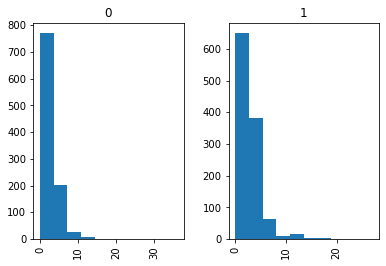

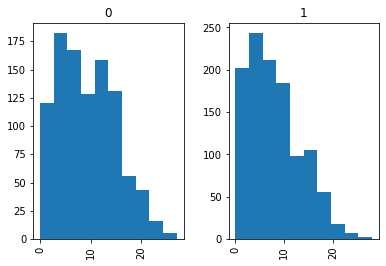

In [27]:
#plotting the distribution between the positive and negative tweets based on character count, hashtags and stop words
df.hist('char_count',by='label')
df.hist('hashtags',by='label')
df.hist('stopwords',by='label')

By looking at the distributions one can see that the distribution for negative and positive sentiment words are different. (more explanation below)

In [28]:
#creating the original dataframe again for analysis and cleaning
df = df[['sentiment', 'negative_reason', 'text']]

Text(0.5, 1.0, 'Canadian Election')

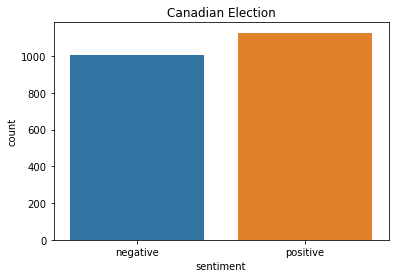

In [29]:
#plotting the sentiment data to see if the data is balanced or not
ax = sns.countplot(x = 'sentiment', data = df )
ax.set_title('Canadian Election')

Based on the graph it can be noted that the data is well balanced

In [30]:
#decoding utf-8 in the text data
df['text'] = df['text'].apply(ast.literal_eval).str.decode("utf-8")

unlike before, lemmatizing is used instead of stemming. This is because stemming was used in the other dataset as there were many records and the tweets were generic so it made more sense to want to get down to the root word to limit the amount of words. For the canadian political election dataset there are much less records and the words could potentially mean more in terms of an election campaign. For example, if stemming were used the word 'conservative' would be stemmed to 'conserv' which would make it harder to determine the different parties each tweet belongs to. 

In [31]:
#this function is used to clean the data
wn = nltk.WordNetLemmatizer()
def clean_text2(text):
    #Replace HTML tag with ascci
    texthtml = html.unescape(text)
    
    # Remove mentions
    textm = re.sub(r'@[A-Za-z0-9_]+', '', texthtml)
    
    # Remove retweets:
    textr = re.sub(r'RT : ', '', textm)
    
    # Remove urls
    texturl = re.sub(r"https?://?\S+", '', textr)
    
    text_lc = "".join([word.lower() for word in texturl if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [wn.lemmatize(word) for word in tokens if word not in stopword]
    return text

In [32]:
#applying the clean_text2 function to clean the data
df['new_text'] = df['text'].apply(clean_text2)

In [33]:
#converting the new text column into a string to allow for further analysis
df['string'] = df['new_text'].apply(listToString)

In [34]:
#viewing the frequencies of the words
freq = pd.Series(' '.join(df['string']).split()).value_counts()[:]
freq.head(20)

elxn             2205
cdnpoli          1167
vote              318
election          249
canada            248
party             226
scheer            207
conservative      193
trudeau           182
canadian          174
chooseforward     169
liberal           164
people            152
cpc               152
like              138
get               137
monday            136
day               134
campaign          134
one               133
dtype: int64

In [35]:
#removing words that have shown up less than 6 times
new_words = freq[freq<6]
df['clean_tweets'] = df['string'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words))

For the next step i removed words based off the freq of each word that can be seen above. This approach is tedious and is typically not recommended as it is not common practice. This step was also only used for the word cloud visualization to get only the meaningful words to be shown in each section. For the actual models and other analysis the clean tweet column is used. 

In [36]:
#removing words based off the freq of each word.
freq= ["elxn" ,"cdnpoli" ,"vote" ,"election" ,"canada" ,"party" ,"canadian" ,"people" ,"like" ,"get" ,"monday" ,"day" ,"campaign" ,"one" ,"need" ,"time" ,"know" ,"candidate" ,"say" ,"want" ,"would" ,"make" ,"right" ,"support" ,"u" ,"see" ,"go" ,"government" ,"question" ,"let" ,"voter" ,"country" ,"cdnelxn" ,"may" ,"think" ,"answer" ,"voting" ,"dont" ,"good" ,"today" ,"canadavotes" ,"year" ,"even" ,"going" ,"political" ,"still" ,"really" ,"take" ,"great" ,"riding" ,"many" ,"thing" ,"last" ,"look" ,"keep" ,"politics" ,"also" ,"door" ,"policy" ,"way" ,"platform" ,"well" ,"back" ,"another" ,"issue" ,"could" ,"guy" ,"he" ,"news" ,"every" ,"come" ,"much" ,"first" ,"yes" ,"stop" ,"poll" ,"two" ,"polcan" ,"care" ,"done" ,"please" ,"new" ,"must" ,"plan" ,"hope" ,"pay" ,"cdnmedia" ,"tell" ,"im" ,"thats" ,"future" ,"best" ,"job" ,"majority" ,"show" ,"said" ,"destroy" ,"bad" ,"wont" ,"never" ,"via" ,"give" ,"put" ,"itsourvote" ,"life" ,"respect" ,"world" ,"story" ,"nothing" ,"next" ,"read" ,"free" ,"true" ,"someone" ,"real" ,"lot" ,"cndpoli" ,"power" ,"firm" ,"got" ,"run" ,"love" ,"cant" ,"stand" ,"mean" ,"big" ,"seat" ,"important" ,"yet" ,"everyone" ,"end" ,"dirty" ,"oh" ,"team" ,"little" ,"seek" ,"full" ,"public" ,"didnt" ,"made" ,"anyone" ,"volunteer" ,"ask" ,"live" ,"hard" ,"worked" ,"paid" ,"comment" ,"believe" ,"sure" ,"watch" ,"seems" ,"remember" ,"thanks" ,"working" ,"final" ,"fact" ,"since" ,"canpoli" ,"away" ,"sign" ,"anything" ,"knock" ,"group" ,"supporter" ,"thought" ,"article" ,"youre" ,"getting" ,"tweet" ,"hire" ,"night" ,"oct" ,"ready" ,"friend" ,"money" ,"deserve" ,"cut" ,"october" ,"chance" ,"maybe" ,"use" ,"asked" ,"ballot" ,"actually" ,"fund" ,"choose" ,"including" ,"thank" ,"billion" ,"point" ,"nation" ,"voted" ,"start" ,"ever" ,"water" ,"else" ,"feel" ,"call" ,"choice" ,"b" ,"across" ,"trying" ,"province" ,"coming" ,"mr" ,"agree" ,"community" ,"video" ,"hey" ,"always" ,"around" ,"wrong" ,"there" ,"matter" ,"check" ,"hand" ,"local" ,"might" ,"pretty" ,"result" ,"continue" ,"talking" ,"hate" ,"whether" ,"close" ,"wonder" ,"hear" ,"ahead" ,"truth" ,"post" ,"fight" ,"member" ,"access" ,"others" ,"without" ,"proud" ,"leadership" ,"enough" ,"former" ,"making" ,"million" ,"st" ,"either" ,"twitter" ,"citizen" ,"service" ,"national" ,"reason" ,"meet" ,"family" ,"thinking" ,"long" ,"everything" ,"value" ,"word" ,"ago" ,"cast" ,"thread" ,"response" ,"using" ,"something" ,"parliament" ,"politician" ,"already" ,"talk" ,"system" ,"part" ,"incredible" ,"doesnt" ,"voice" ,"message" ,"become" ,"head" ,"cannot" ,"house" ,"home" ,"bring" ,"elect" ,"fear" ,"interesting" ,"looking" ,"listen" ,"trust" ,"whats" ,"expect" ,"minute" ,"learn" ,"running" ,"w" ,"number" ,"company" ,"clear" ,"instead" ,"far" ,"environment" ,"lead" ,"try" ,"office" ,"living" ,"month" ,"together" ,"consultant" ,"isnt" ,"move" ,"given" ,"child" ,"week" ,"report" ,"opponent" ,"view" ,"watching" ,"sun" ,"turn" ,"rule" ,"coverage" ,"cost" ,"positive" ,"lose" ,"current" ,"claim" ,"called" ,"find" ,"desperate" ,"campaigning" ,"polling" ,"share" ,"gonna" ,"hiring" ,"interest" ,"break" ,"heading" ,"possible" ,"bill" ,"canadaelection" ,"reporter" ,"elected" ,"yeah" ,"entire" ,"govt" ,"happen" ,"weve" ,"hour" ,"decide" ,"shit" ,"stay" ,"worse" ,"morning" ,"champion" ,"common" ,"industry" ,"wait" ,"centre" ,"told" ,"asking" ,"four" ,"tool" ,"kind" ,"place" ,"law" ,"speak" ,"clearly" ,"huge" ,"weekend" ,"folk" ,"failed" ,"affordable" ,"knew" ,"period" ,"supporting" ,"consulting" ,"justice" ,"globe" ,"amazing" ,"reporting" ,"difference" ,"exactly" ,"able" ,"theyre" ,"morally" ,"nice" ,"wow" ,"high" ,"seem" ,"ok" ,"protection" ,"game" ,"thousand" ,"understand" ,"benefit" ,"energy" ,"sorry" ,"guess" ,"id" ,"beautiful" ,"tight" ,"name" ,"line" ,"found" ,"quite" ,"top" ,"due" ,"helping" ,"play" ,"ad" ,"seriously" ,"here" ,"forget" ,"whatever" ,"fighting" ,"hold" ,"consider" ,"likely" ,"process" ,"whole" ,"especially" ,"gotta" ,"meeting" ,"form" ,"term" ,"came" ,"belief" ,"saying" ,"lost" ,"ppl" ,"calling" ,"almost" ,"owned" ,"heard" ,"area" ,"truly" ,"problem" ,"false" ,"air" ,"wondering" ,"legal" ,"seen" ,"focus" ,"who" ,"program" ,"wage" ,"clean" ,"document" ,"heart" ,"integrity" ,"age" ,"deserves" ,"side" ,"set" ,"gotv" ,"business" ,"damn" ,"position" ,"concern" ,"feeling" ,"source" ,"strategy" ,"used" ,"definitely" ,"dollar" ,"count" ,"deficit" ,"imagine" ,"three" ,"online" ,"except" ,"worst" ,"return" ,"worth" ,"low" ,"fall" ,"star" ,"press" ,"challenge" ,"lol" ,"career" ,"major" ,"based" ,"visit" ,"fellow" ,"global" ,"sent" ,"promised" ,"serious" ,"record" ,"outcome" ,"behind" ,"threat" ,"build" ,"crowd" ,"held" ,"gas" ,"showing" ,"unless" ,"behaviour" ,"society" ,"strategist" ,"follow" ,"statement" ,"join" ,"mind" ,"accountable" ,"effective" ,"agreement" ,"newspaper" ,"took" ,"ensure" ,"advance" ,"giving" ,"complete" ,"several" ,"personal" ,"staff" ,"along" ,"represent" ,"nonsense" ,"deal" ,"yr" ,"fair" ,"topic" ,"paying" ,"spent" ,"state" ,"winning" ,"ive" ,"rest" ,"human" ,"th" ,"dream" ,"grow" ,"threatened" ,"box" ,"reminder" ,"endorse" ,"mark" ,"built" ,"north" ,"proven" ,"cdnvote" ,"open" ,"informed" ,"train" ,"discus" ,"different" ,"spread" ,"responsible" ,"mistake" ,"defeat" ,"require" ,"push" ,"endorsed" ,"fit" ,"person" ,"respond" ,"connection" ,"expert" ,"class" ,"main" ,"holding" ,"transfer" ,"alone" ,"weakandy" ,"coast" ,"relationship" ,"brought" ,"gone" ,"youth" ,"york" ,"stupid" ,"protect" ,"attempt" ,"sense" ,"decision" ,"stake" ,"cause" ,"yesterday" ,"senior" ,"negative" ,"arent" ,"piece" ,"demand" ,"target" ,"electoral" ,"wk" ,"vendor" ,"wrote" ,"adequate" ,"surprise" ,"step" ,"editorial" ,"case" ,"mission" ,"opposition" ,"pocket" ,"transition" ,"discussing" ,"room" ,"named" ,"needed" ,"wing" ,"however" ,"simple" ,"least" ,"card" ,"journalism" ,"search" ,"control" ,"regardless" ,"america" ,"action" ,"individual" ,"tactic" ,"obviously" ,"gave" ,"coal" ,"anymore" ,"account" ,"max" ,"stretch" ,"operative" ,"honestly" ,"wasnt" ,"taking" ,"responds" ,"paper" ,"example" ,"honesty" ,"advice" ,"buy" ,"second" ,"wish" ,"dirt" ,"mill" ,"absolute" ,"building" ,"list" ,"accept" ,"sound" ,"known" ,"half" ,"probably" ,"whose" ,"higher" ,"quality" ,"hoping" ,"level" ,"late" ,"happy" ,"board" ,"happened" ,"present" ,"ethical" ,"perhaps" ,"website" ,"research" ,"reelected" ,"facing" ,"region" ,"block" ,"influence" ,"latest" ,"refuse" ,"mouth" ,"photo" ,"officially" ,"representing" ,"completely" ,"ill" ,"wake" ,"stuff" ,"supposed" ,"leading" ,"economic" ,"early" ,"contract" ,"data" ,"worker" ,"satire" ,"outside" ,"though" ,"cabinet" ,"actual" ,"figure" ,"decided" ,"sad" ,"welcome" ,"favourite" ,"fan" ,"caught" ,"light" ,"willing" ,"single" ,"sold" ,"blocked" ,"involved" ,"solid" ,"hit" ,"straight" ,"lack" ,"simply" ,"interview" ,"prevent" ,"afraid" ,"principled" ,"security" ,"wouldnt" ,"attacking" ,"raise" ,"throw" ,"cluckcluck" ,"hasnt" ,"direction" ,"bigger" ,"canvas" ,"neighbour" ,"hedge" ,"happening" ,"ridiculous" ,"address" ,"beyond" ,"partner" ,"attention" ,"allowed" ,"breaking" ,"send" ,"union" ,"style" ,"experience" ,"divisive" ,"movement" ,"rebel" ,"totally","leader" ,"help" ,"federal" ,"hired" ,"medium" ,"win" ,"work" ,"better" ,"mp" ,"onpoli" ,"minister" ,"endorsement" ,"ontario" ,"lying" ,"prime" ,"cbc" ,"man" ,"ottawa" ,"bc" ,"progressive" ,"social" ,"debate" ,"fake" ,"getoutthevote" ,"race" ,"foreign" ,"postmedia" ,"le" ,"jwr" ,"old" ,"rally" ,"attack" ,"endorsing" ,"toronto" ,"history" ,"young" ,"committed" ,"forward" ,"ottawacentre" ,"strong" ,"vancouver" ,"representationmatters" ,"health" ,"strategically" ,"kid" ,"animal" ,"defundcbc" ,"regina" ,"daisy" ,"crpd" ,"crisis" ,"powertotheinformed" ,"racism" ,"democratic" ,"abc" ,"west" ,"vanpoli" ,"gpc" ,"vangran" ,"strategic" ,"pharmacare" ,"debt" ,"market" ,"education" ,"healthcare" ,"rich" ,"partisan" ,"housing" ,"canvassing" ,"ontpoli" ,"lisa" ,"fakenews" ,"yyc" ,"corrupt" ,"hamish" ,"god" ,"calgary" ,"boy" ,"school" ,"student" ,"son" ,"war" ,"homefamily" ,"proportionalrepresentation" ,"poverty" ,"regime" ,"conference" ,"agenda" ,"despicable" ,"cdn" ,"freedom" ,"qc" ,"msm" ,"activist" ,"crime" ,"ctv" ,"simcoenorth" ,"illegal" ,"crooked" ,"std" ,"journalist" ,"white" ,"china" ,"rd" ,"planet" ,"jean" ,"bias" ,"progress" ,"budget" ,"radical" ,"fire" ,"stock" ,"smart" ,"guelph" ,"miltonon" ,"misinformation" ,"raitt" ,"marshall" ,"adam" ,"ab" ,"deep" ,"troll" ,"kamloops" ,"split"]
df['final_tweets'] = df['clean_tweets'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

These are the actual manual words i removed for the clean_tweets data that is used for the model and other analysis

## Q2 Exploratory Analysis

Determining the political party (Liberal, Conservative, or New Democratic Party (NDP)) of a given tweet
1. Assigning speciifc words to the political parties to assign each tweet based on the freqnecy of the words chosen political party 
    for example: if a tweet has 3/5 words associated with the Liberal party, that tweet falls under liberal
2. After assigning each tweet to a party, the sentiment of the tweet is then taken into account to decided whether that political party is appropriate for that tweet or not. 
    for example: if a tweet was categorized as liberal but has a negative sentiment then the party is changed to conservative
    
The logic for switching the parties based off their sentiment is by this: 
- if liberal and negative -> conservative
- if conservative and negative -> liberal 
- if ndp and negative -> conservative 
The reason why liberal and conservative get switched out for each other is because the canadian election is typically between liberals and conservatives (based on past elections) therefore i find that most of the debate is between those two parties. I understand this is an assumption and can change the analysis and sentiment prediction of these tweets but from personal experience and past elections i believe it is appropriate. Other is not changed here as they fall under the other category so it is harder to determine. 

Step 1: Assigning specific words and categorizing tweets into parties 

In [37]:
#creating a procedure to group the tweets by political party
def party(text): 
    #assigning certain words to parties based on the freq of each word that was printed out in the data cleaning section
    liberal = ["chooseforward" ,"lpc" ,"left" ,"chooseforwardwithtrudeau" ,"nbpoli" ,"nspoli" ,"teamtrudeau" ,"nlpoli" ,"indigenous" ,"peipoli" ,"voteliberal" ,"nwtpoli" ,"science" ,"nspolitics" ,"votingliberal", "trudeau" ,"liberal" ,"lie" ,"trudeaumustgo" ,"change" ,"pm" ,"justin" ,"con" ,"racist" ,"scandal" ,"economy" ,"promise" ,"liar" ,"black" ,"corruption" ,"trudeaublackface" ,"blackface" ,"face" ,"mbpoli" ,"libs" ,"ethic" ,"trudeaus" ,"chrétien" ,"trudeauworstpm" ,"transparent" ,"obama" ,"lied" ,"fraud" ,"transparency" ,"unethical" ,"honest" ,"snclavalinscandal" ,"unfit" ,"guilty" ,"mckenna" ,"powerhungrylibcons" ,"father" ,"veteran" ,"fptp" ,"investigation" ,"shame" ,"trudeamustgo" ,"criminal" ,"lib" ,"snclavalin"]
    conservative = ["cpc" ,"abpoli" ,"alberta" ,"smear" ,"skpoli" ,"tax" ,"oil" ,"democracy" ,"scheerpm" ,"yeg" ,"farright" ,"taxpayer" ,"gst" ,"blue" ,"antiabortion","scheer" ,"conservative" ,"kinsella" ,"kinsellagate" ,"climate" ,"andrew" ,"warren" ,"scheerlies" ,"american" ,"ableg" ,"milton" ,"woman" ,"scheerdisaster" ,"andy" ,"andrewscheer" ,"harper" ,"past" ,"abortion" ,"trump" ,"scheerhypocrisy" ,"scheers" ,"ford" ,"tory" ,"quebec" ,"climatechange" ,"climateaction" ,"stopscheer" ,"doug" ,"lyingandy" ,"nocpc" ,"yankeedoodleandy" ,"warrenkinsella" ,"lgbtq" ,"sheer" ,"neverscheer" ,"trudeaucorruption" ,"kinsellouts" ,"climatecrisis" ,"kinsellas" ,"scheerdesperation" ,"anxiousandrew" ,"immigration" ]
    ndp = ["ndp" ,"uprisingh" ,"bcpoli" ,"singh" ,"jagmeet" ,"minority" ,"coalition" ,"initforyou" ,"singhsurge" ,"votendp","pipeline" , "extremist" ,"jagmeetsingh"]
    other = ["ppc" ,"green" ,"bernier" ,"maxime" ,"voteppc" ,"polqc" ,"qcpoli" ,"peoplespartyofcanada" ,"elizabeth" ,"maximebernier" ,"choosemaxime" ,"bloc" ,"berniers" ,"greenparty" ,"votegreen" ,"undecided" ,"votesplitting" ,"ppcmajority"]

    party = []
    
    #if the word is associated with a chosen liberal word then replace it as liberal
    for word in liberal:   
        if word in text:
            party.append('Liberal')
    #if the word is associated with a chosen conservative word then replace it as conservative
    for word in conservative:   
        if word in text:
            party.append('Conservative')
    #if the word is associated with a chosen NDP word then replace it as NDP
    for word in ndp:   
        if word in text:
            party.append('NDP')
    #if the word is associated with a chosen Other word then replace it as Other        
    for word in other:   
        if word in text:
            party.append('Other')
    
    #determining which category the tweet falls under and if none then put under Other 
    if len(party) > 1:
        most_common = max(set(party), key=party.count)
        party = []
        party.append(most_common)
    elif len(party) == 0:
        party.append('Other')
    
    return party

#applying the function to the clean_tweets and then converting it into a string
df['party'] = df['clean_tweets'].apply(party)
df['party'] = df['party'].str[0]

Step 2: Taking the sentiment into account and re allocating the tweets into parties 

In [38]:
#taking into account the sentiment for conservative allocated tweets
df['actualparty'] = np.where((df['party'] == 'Conservative')&
                          (df['sentiment'] == "negative")
                          
                          , 'Liberal', df['party'])


In [39]:
#taking into account the sentiment for Liberal allocated tweets
df['actualparty'] = np.where((df['party'] == 'Liberal')&
                          (df['sentiment'] == "negative")
                          
                          , 'Conservative', df['actualparty'])

In [40]:
#taking into account the sentiment for NDP allocated tweets
df['actualparty'] = np.where((df['party'] == 'NDP')&
                          (df['sentiment'] == "negative")
                          
                          , 'Conservative', df['actualparty'])

In [41]:
df.head()

,sentiment,negative_reason,text,new_text,string,clean_tweets,final_tweets,party,actualparty
0,negative,Women Reproductive right and Racism,"@RosieBarton So instead of your suggestion, ho...","[, instead, suggestion, agree, canadian, woman...",instead suggestion agree canadian woman trust...,instead agree canadian woman trust andrewschee...,woman andrewscheer conservative woman abortion,Conservative,Liberal
1,positive,NaN,#AllWomanSpacewalk it's real!\n@Space_Station ...,"[allwomanspacewalk, real, etobicokenorth, city...",allwomanspacewalk real etobicokenorth cityofto...,real onpoli cdnpoli elxn,,Other,Other
2,negative,Economy,#Brantford It's going to cost YOU $94 BILLION ...,"[brantford, going, cost, billion, next, year, ...",brantford going cost billion next year ask jus...,going cost billion next year ask justin elxn c...,justin,Liberal,Conservative
3,positive,NaN,#Canada #CanadaElection2019 #CanadaVotes \n#el...,"[canada, canadaelection, canadavotes, elxn, ca...",canada canadaelection canadavotes elxn cant de...,canada canadaelection canadavotes elxn cant de...,,Other,Other
4,negative,Economy,#Canada #taxpayers are sick &amp; tired of hav...,"[canada, taxpayer, sick, tired, hard, earned, ...",canada taxpayer sick tired hard earned donated...,canada taxpayer hard dont need one many reason...,taxpayer trudeaumustgo snclavalinscandal,Liberal,Conservative


In [42]:
#viewing the allocated party count before incorporating sentiment
df.party.value_counts()

Liberal         824
Other           664
Conservative    516
NDP             129
Name: party, dtype: int64

In [43]:
#viewing the allocated party count after incorporating sentiment
df.actualparty.value_counts()

Liberal         752
Other           664
Conservative    632
NDP              85
Name: actualparty, dtype: int64

By comparing the party and actual party value counts one can see these differences: 
- Liberal decreased by 72
- Conservative increased by 116
- NDP decreased by 44
- Other stayed the same (as it should have) 

### Visualization of Tweets

1. Generic Tweets in sentiment_analysis.csv
2. 2019 Canadian Election Tweets

#### 1. Generic Tweets

Text(0.5, 1.0, 'General Tweets')

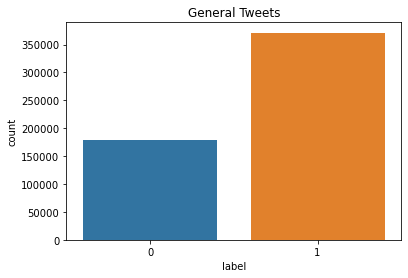

In [44]:
#plotting a bar graph to see the difference in positive and negative tweets
ax = sns.countplot(x = 'label', data = df2 )
ax.set_title('General Tweets')

Based on the graph you can see that there are much more positive tweets than there are negative. Just based on the graph it looks to have roughly about 50% less negative tweets than positive

#### Wordplot for Generic Tweets
A wordplot is then created to visually see the most occuring words in all the tweets, negative sentiment tweets and positive sentiment tweets after data cleaning. This gives you a good idea as to what key words could potentially be the cause of the negative or positive sentiment.

(-0.5, 399.5, 199.5, -0.5)

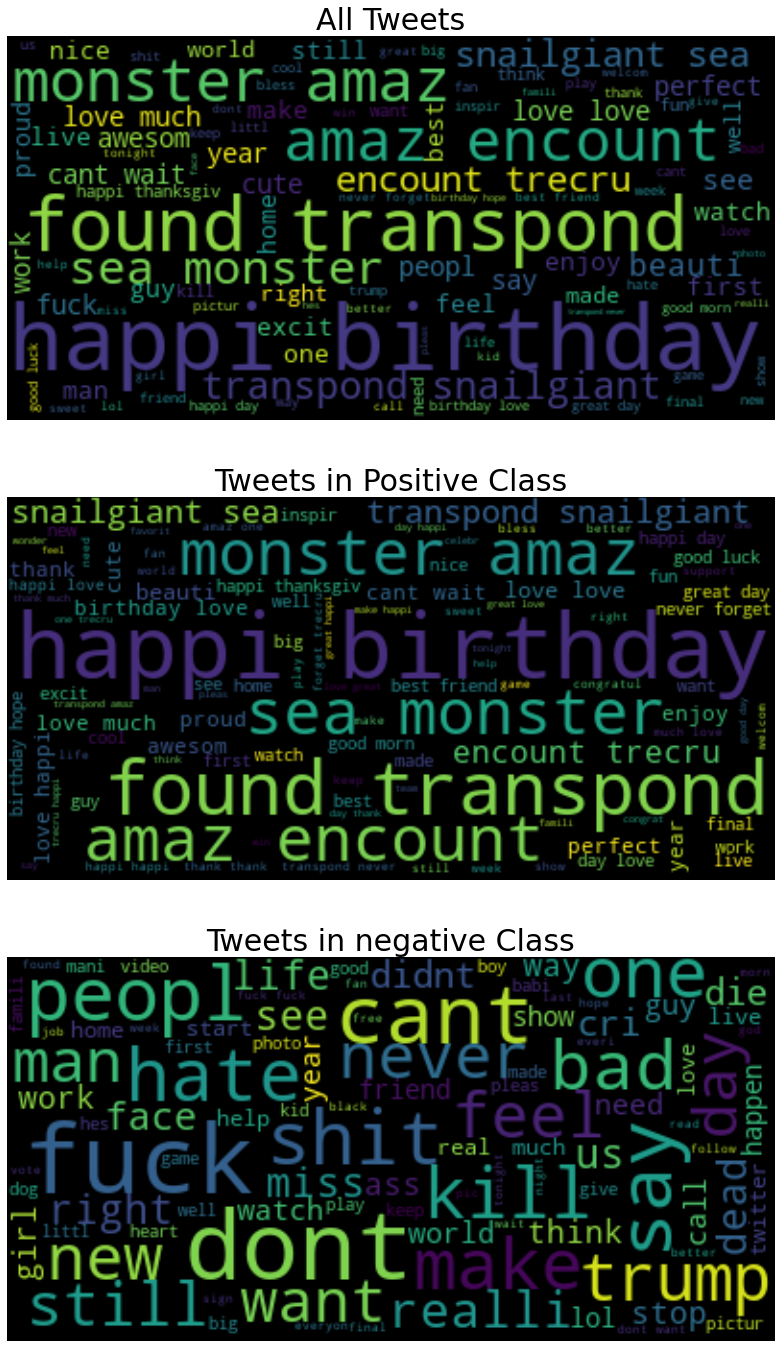

In [45]:
#wordplot creation
df2_positive = df2[df2['sentiment']== "positive"]
df2_negative = df2[df2['sentiment']== "negative"]
tweet_All = " ".join(review for review in df2.done_tweets)
tweet_positive = " ".join(review for review in df2_positive.done_tweets)
tweet_negative = " ".join(review for review in df2_negative.done_tweets)

fig, ax = plt.subplots(3, 1, figsize  = (25,24))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100).generate(tweet_All)
wordcloud_positive = WordCloud(max_font_size=50, max_words=100).generate(tweet_positive)
wordcloud_negative = WordCloud(max_font_size=50, max_words=100).generate(tweet_negative)


# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_positive , interpolation='bilinear')
ax[1].set_title('Tweets in Positive Class',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_negative, interpolation='bilinear')
ax[2].set_title('Tweets in negative Class',fontsize=30)
ax[2].axis('off')

#### 1. 2019 Canadian Election tweets

Text(0.5, 1.0, 'Canadian Election')

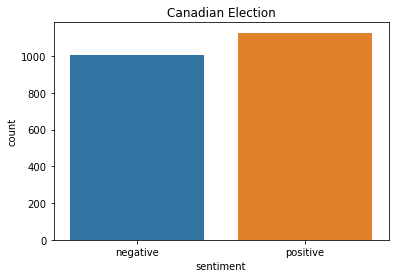

In [46]:
#comparing the negative and positive amount of tweets
ax = sns.countplot(x = 'sentiment', data = df )
ax.set_title('Canadian Election')

Based on the graph you can see that the negative and positive tweets are pretty balanced in the data set

[Text(0.5, 0, 'Negative Reason'), Text(0, 0.5, 'Tweet Count')]

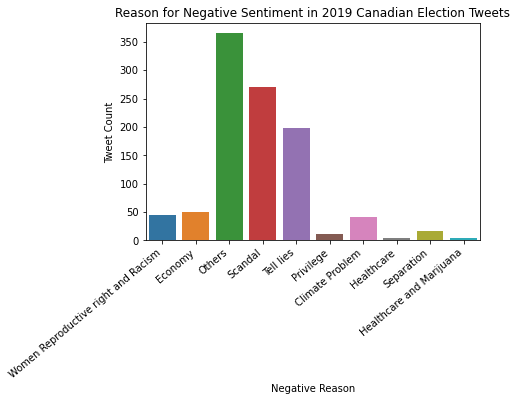

In [47]:
#creating plot to see the amount of negative reasoning for the tweets
ax = sns.countplot(x = 'negative_reason', data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Reason for Negative Sentiment in 2019 Canadian Election Tweets")
ax.set(xlabel = 'Negative Reason', ylabel = 'Tweet Count')

Based on this graph you can see that most of the negative tweets are due to "other" reasons than listed here but "Scandal" is the next top reason for the negative tweets. The order for reasoning for negative tweets is below:

In [48]:
#viewing the distribution of reasons for negative tweets
df.negative_reason.value_counts()

Others                                 365
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

#### Wordplot for 2019 Canadian Election Tweets
Same reasoning as the generic tweets are applied here for the use of wordplots. In these wordplots however, one can notice that a lot of the words are actually seen in both the negative and the positive tweets, there is not as much differentiation like the generic wordplot tweets from above. Also, something to note is that words that are associated to all the parties are in both the negative and positive word clouds so that can also cause some issues when trying to determine how to group the tweets by political party. This is just an indication that is will be harder to determine political party based on sentiment since a lot of the words crossover. 

(-0.5, 399.5, 199.5, -0.5)

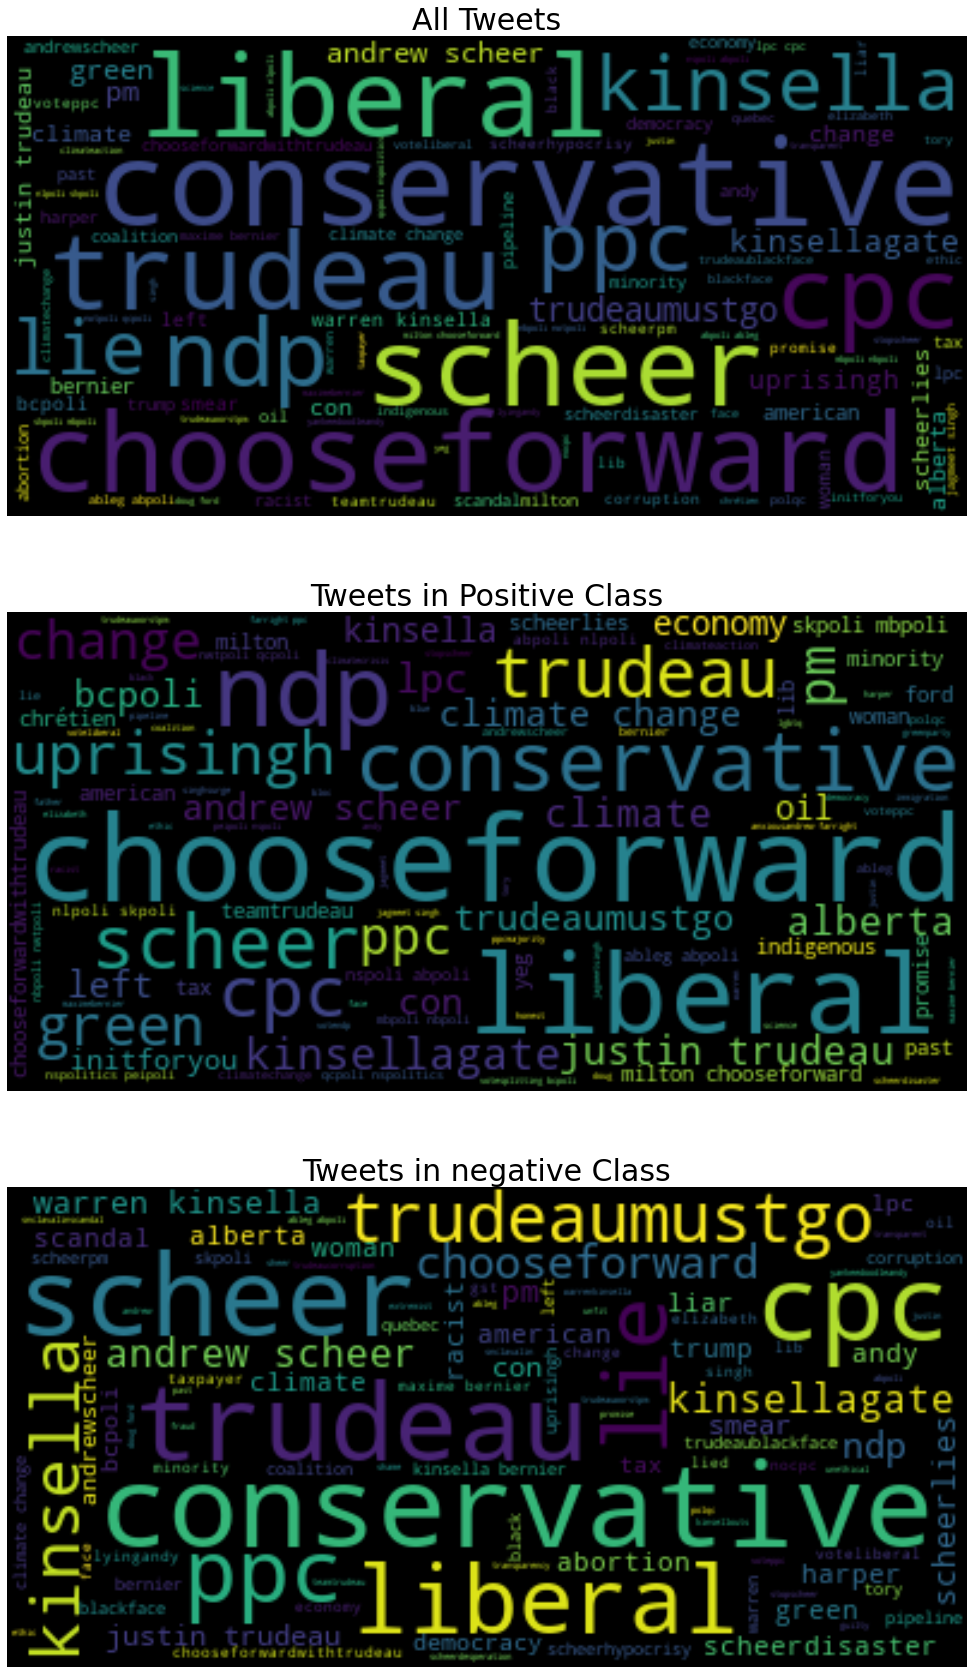

In [49]:
#Creating wordplot
df_positive = df[df['sentiment']== "positive"]
df_negative = df[df['sentiment']== "negative"]
tweet_All = " ".join(review for review in df.final_tweets)
tweet_positive = " ".join(review for review in df_positive.final_tweets)
tweet_negative = " ".join(review for review in df_negative.final_tweets)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100).generate(tweet_All)
wordcloud_positive = WordCloud(max_font_size=50, max_words=100).generate(tweet_positive)
wordcloud_negative = WordCloud(max_font_size=50, max_words=100).generate(tweet_negative)


# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_positive , interpolation='bilinear')
ax[1].set_title('Tweets in Positive Class',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_negative, interpolation='bilinear')
ax[2].set_title('Tweets in negative Class',fontsize=30)
ax[2].axis('off')

## Q3 Model Preparation

- Using Generic Tweet Data
- Split tweets 70% training and 30% test
- logisitc regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest and XGBoost
- target variable = sentiment value (positive/negative)
- Two different types of features: Bag of Words (bow) and TF-IDF

Both different features will be applied to the 7 models therefore we will have a total of 14 models

In [50]:
#importing all required libraries for the following steps
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
#pip install xgboost (may need this before running)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer, confusion_matrix, f1_score, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report 
from statistics import *
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [51]:
df2

,text,label,sentiment,clean_text,string,clean_tweets,done_tweets
0,Josh Jenkins is looking forward to TAB Breeder...,1,positive,"[josh, jenkin, look, forward, tab, breeder, cr...",josh jenkin look forward tab breeder crown sup...,look,
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1,positive,"[congratul, pakistan, becom, notestteam, world...",congratul pakistan becom notestteam world odd ...,congratul world,congratul world
2,"RT @PEPalerts: This September, @YESmag is taki...",1,positive,"[septemb, take, main, mendoza, surpris, thanks...",septemb take main mendoza surpris thanksgiv pa...,take thanksgiv fan,thanksgiv fan
3,"RT @david_gaibis: Newly painted walls, thanks ...",1,positive,"[newli, paint, wall, thank, million, custodi, ...",newli paint wall thank million custodi painter...,thank great job,thank great job
4,RT @CedricFeschotte: Excited to announce: as o...,1,positive,"[excit, announc, juli, feschott, lab, reloc, m...",excit announc juli feschott lab reloc mbg,excit,excit
...,...,...,...,...,...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0,negative,"[, cant, stop, watch, hermm, ]",cant stop watch hermm,cant stop watch,cant stop watch
550387,Poor old Tom Odell doesn't look like he would ...,0,negative,"[poor, old, tom, odel, doesnt, look, like, wou...",poor old tom odel doesnt look like would know ...,look like would know,like
550388,#antsmasher I smashed 7 ants in this awesome ...,1,positive,"[antsmash, smash, ant, awesom, gamehjfjfi, ]",antsmash smash ant awesom gamehjfjfi,awesom,awesom
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,positive,"[, morn, girl, wonder, friday, ]",morn girl wonder friday,morn girl wonder friday,morn girl wonder friday


#### Splitting the Data

The data is split before feature encoding to limit any data leaking into the testing sets

In [52]:
#train test split 
X = df2['done_tweets']
y = df2['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [53]:
print (X_train.shape)
print (X_test.shape)

(385273,)
(165118,)


#### Feature Encoding 

In [54]:
# Bag of Words feature encoding.
bow = CountVectorizer(max_features=200).fit(X_train) # Number of features are limited to the top by term frequency.
bowx_train = bow.transform(X_train).toarray()
bowx_test = bow.transform(X_test).toarray()

In [55]:
# TF-IDF feature encoding.
TFIDF = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=200).fit(X_train) # Number of features are limited to the top by term frequency.
TFIDFx_train = TFIDF.transform(X_train).toarray()
TFIDFx_test = TFIDF.transform(X_test).toarray()

#### Classification Algorithms

For each of the classification models some pros and cons are listed to see the value in each model. There are more pros and cons associated with each of the models but only a couple are listed here.

##### Logistic Regression
- Pros: Simple to implement, Effective, Feature scaling not needed
- Cons: Poor performance with irrelevant and highly correlated features, high reliance on proper presentation of data, typically can be outperformed by other models

In [56]:
#function for Logisitic Regression model
def LR(X_train, X_test, y_train, y_test):
    
    LR_model = LogisticRegression( random_state=1)
    LR_model.fit(X_train, y_train)
    predictions = LR_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [57]:
#running the model with bow and TF-IDF and printing out the accuracy scores
LR_bow = LR(bowx_train, bowx_test, y_train, y_test)
print('Bow Accuracy Score: %.5f' % (LR_bow))

LR_TFIDF = LR(TFIDFx_train, TFIDFx_test, y_train, y_test)
print('TF-IDF Accuracy Score: %.5f' % (LR_TFIDF))

Bow Accuracy Score: 0.88385
TF-IDF Accuracy Score: 0.88387


##### K Nearest Neighbors
- Pros: Simple to implement, No assumption about the data, Model changes to accomate new data points
- Cons: Slow for large datasets, Sensitive to outliers

In [58]:
#function for k-NN model
def KNN(X_train, X_test, y_train, y_test):
    
    KNN_model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    KNN_model.fit(X_train, y_train)
    predictions = KNN_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [59]:
#running the model with bow and TF-IDF and printing out the accuracy scores
KNN_bow = KNN(bowx_train, bowx_test, y_train, y_test)
print('Bow Accuracy Score: %.5f' % (KNN_bow))

KNN_TFIDF = KNN(TFIDFx_train, TFIDFx_test, y_train, y_test)
print('TF-IDF Accuracy Score: %.5f' % (KNN_TFIDF))

Bow Accuracy Score: 0.81290
TF-IDF Accuracy Score: 0.80993


##### Naive Bayes
- Pros: good performance with high dimensional data, real time predictions, scalable with large datasets
- Cons: Independence of features does not hold, training data should present data well

In [60]:
#function for Naive Bayes model
def NB(X_train, X_test, y_train, y_test):

    NB_model = GaussianNB()
    NB_model.fit(X_train, y_train)
    predictions = NB_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [61]:
#running the model with bow and TF-IDF and printing out the accuracy scores
NB_bow = NB(bowx_train, bowx_test, y_train, y_test)
print('Bow Accuracy Score: %.5f' % (NB_bow))

NB_TFIDF = NB(TFIDFx_train, TFIDFx_test, y_train, y_test)
print('TF-IDF Accuracy Score: %.5f' % (NB_TFIDF))

Bow Accuracy Score: 0.83054
TF-IDF Accuracy Score: 0.83052


##### Support Vector Machine (SVM) / Linear SVC
- Pros: performs well in higher dimension, outliers have less impact, good algorithm when classes are seperable
- Cons: slow for large datasets, selecting appropriate hyperparameters is important

In [62]:
#function for Linear SVC model
def SVM(X_train, X_test, y_train, y_test):
    
    SVM_model = LinearSVC()
    SVM_model.fit(X_train, y_train)
    predictions = SVM_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [63]:
#running the model with bow and TF-IDF and printing out the accuracy scores
SVM_bow = SVM(bowx_train, bowx_test, y_train, y_test)
print('Bow Accuracy Score: %.5f' % (SVM_bow))

SVM_TFIDF = SVM(TFIDFx_train, TFIDFx_test, y_train, y_test)
print('TF-IDF Accuracy Score: %.5f' % (SVM_TFIDF))

Bow Accuracy Score: 0.88328
TF-IDF Accuracy Score: 0.88345


##### Decision Trees
- Pros: normalization and scaling not needed, easy visualization, automatic feature selection
- Cons: prone to overfitting, sensitive to data changes

In [64]:
#function for Decision Trees model
def DT(X_train, X_test, y_train, y_test):
    
    DT_model = DecisionTreeClassifier(random_state=1)
    DT_model.fit(X_train, y_train)
    predictions = DT_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [65]:
#running the model with bow and TF-IDF and printing out the accuracy scores
DT_bow = DT(bowx_train, bowx_test, y_train, y_test)
print('Bow Accuracy Score: %.5f' % (DT_bow))

DT_TFIDF = DT(TFIDFx_train, TFIDFx_test, y_train, y_test)
print('TF-IDF Accuracy Score: %.5f' % (DT_TFIDF))

Bow Accuracy Score: 0.88443
TF-IDF Accuracy Score: 0.88443


##### Random Forest
- Pros: good performance on imbalanced datasets, good at handing large amounts of data, little impact from outliers
- Cons: features need to have some predictive power, predictions need to be uncorrelated

In [66]:
#function for Random Forest model
def RF(X_train, X_test, y_train, y_test):
    
    RF_model = RandomForestClassifier(random_state=1)
    RF_model.fit(X_train, y_train)
    predictions = RF_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [67]:
#running the model with bow and TF-IDF and printing out the accuracy scores
RF_bow = RF(bowx_train, bowx_test, y_train, y_test)
print('Bow Accuracy Score: %.5f' % (RF_bow))

RF_TFIDF = RF(TFIDFx_train, TFIDFx_test, y_train, y_test)
print('TF-IDF Accuracy Score: %.5f' % (RF_TFIDF))

Bow Accuracy Score: 0.88740
TF-IDF Accuracy Score: 0.88740


##### XGBoost
- Pros: less feature engineering typically required, outliers have minimal impact, hanldes large sized data well, less prone to overfitting
- Cons: hard to visualize, harder to tune as there are many hyperparameters

In [68]:
#function for XGBoost model
def XGB(X_train, X_test, y_train, y_test):
    
    XGB_model = XGBClassifier(random_state=1)
    XGB_model.fit(X_train, y_train)
    predictions = XGB_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [69]:
#running the model with bow and TF-IDF and printing out the accuracy scores
XGB_bow = XGB(bowx_train, bowx_test, y_train, y_test)
print('Bow Accuracy Score: %.5f' % (XGB_bow))

XGB_TFIDF = XGB(TFIDFx_train, TFIDFx_test, y_train, y_test)
print('TF-IDF Accuracy Score: %.5f' % (XGB_TFIDF))

[01:17:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Bow Accuracy Score: 0.88628
[01:36:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TF-IDF Accuracy Score: 0.88628


## Q4 Model Implementation and Tuning 

Based off the 14 models that were run the top 3 models based on accuracy were: 
1. RandomForestClassifier
2. XGBClassifier
3. DecisionTreeClassifier

It wasnt too much of a surprise that these were the top 3 best models due to the characteristics mentioned in the pros/cons for each model. 

Therefore RandomForestClassifier has the best performance and will be used on the Canadian Elections Data

### Testing best trained model on the Canadian Elections Data

In [70]:
#assinging features and target variables
X2 = df['clean_tweets']
y2 = df['sentiment']

In [71]:
# Bag of Words feature encoding.
bowce = CountVectorizer(max_features=148).fit(X2) # Number of features are limited to the top by term frequency.
bowx = bowce.transform(X2).toarray()

#### Best Model: 

To better see the difference between the accuracy on the training set and on the test set, they are both outputted. 

In [72]:
#Evaluating the best model on the canadian election dataset

#running the best model again
best_model = RandomForestClassifier( random_state=1)
best_model.fit(bowx_train, y_train)

train_pred = best_model.predict(bowx_train)
train_acc = accuracy_score(y_train, train_pred)

#testing the model on the canadian election dataset
test_pred = best_model.predict(bowx)
test_acc = accuracy_score(y2, test_pred)

print(' Trained Model: %.3f, Election dataset: %.3f' % (train_acc, test_acc))

 Trained Model: 0.905, Election dataset: 0.496


Based on the accuracy scores, the predictions do not match the sentiment labelled in the Canadian elections data well at all. The model reached 0.496 accuracy which is basically a random guess. Having a trained model with such a high accuracy and low accuracy for test data indicates a very overfit model. This means that the model has low bias and high variance. A model with this high of an accuracy score on the trained model typically means that something needs to be changed in the data cleaning stages as 90% is too high and indicates that the model is overfit right from the beginning. This may not always be the case, but in this case, it is true. 

#### Evaluating Based on the 3 parties 

To evaluation the sentiment prediction results and the true sentiment for each of the 3 political parties i did the following: 
- created a classreport and accscore to store each political parties results for further analysis
- The same steps were done for all 3 political parties: 
    1. Filter for the specific political party 
    2. Assign features and target variables
    3. use bag of words for feature encoding and use the best_model from the previous step to get predictions
    4. get accuracy score and classification report for comparison and results
    5. create a dataframe that has the party, true sentiment value and predicted sentiment value 
    6. Print the accuracy score and classification report
- Once completed for all political parties, the dataframe that was created for each is combined for further analysis below

In [73]:
#Evaluating the 3 political parties for further analysis and visualizating
classreport = {}
accscore = []

#Liberal results
party = 'Liberal'
print(party)
df_party = df[df['actualparty']==party]
X2, y2 = df_party['clean_tweets'].values, df_party['sentiment'].values
X2 = bowce.transform(X2).toarray()
y_pred =  best_model.predict(X2)
ACC = accuracy_score(y2, y_pred)
accscore.append(ACC)
classreport[party] = classification_report(y2, y_pred, output_dict=True)

liberal_results = pd.DataFrame(
    {'party': party,
     'true_sentiment': y2,
     'pred_sentiment': y_pred
    })

print('Accuracy: %.5f' % (ACC))
print(classification_report(y2, y_pred))

#Conservative Results
party = 'Conservative'
print(party)
df_party = df[df['actualparty']==party]
X2, y2 = df_party['clean_tweets'].values, df_party['sentiment'].values
X2 = bowce.transform(X2).toarray()
y_pred =  best_model.predict(X2)
ACC = accuracy_score(y2, y_pred)
accscore.append(ACC)
classreport[party] = classification_report(y2, y_pred, output_dict=True)

cons_results = pd.DataFrame(
    {'party': party,
     'true_sentiment': y2,
     'pred_sentiment': y_pred
    })

print('Accuracy: %.5f' % (ACC))
print(classification_report(y2, y_pred))

#NDP Results
party = 'NDP'
print(party)
df_party = df[df['actualparty']==party]
X2, y2 = df_party['clean_tweets'].values, df_party['sentiment'].values
X2 = bowce.transform(X2).toarray()
y_pred =  best_model.predict(X2)
ACC = accuracy_score(y2, y_pred)
accscore.append(ACC)
classreport[party] = classification_report(y2, y_pred, output_dict=True)

ndp_results = pd.DataFrame(
    {'party': party,
     'true_sentiment': y2,
     'pred_sentiment': y_pred
    })

print('Accuracy: %.5f' % (ACC))
print(classification_report(y2, y_pred))

Liberal
Accuracy: 0.40027
              precision    recall  f1-score   support

    negative       0.31      0.29      0.30       331
    positive       0.47      0.48      0.47       421

   micro avg       0.40      0.40      0.40       752
   macro avg       0.39      0.39      0.39       752
weighted avg       0.40      0.40      0.40       752

Conservative
Accuracy: 0.54272
              precision    recall  f1-score   support

    negative       0.77      0.50      0.61       447
    positive       0.35      0.65      0.45       185

   micro avg       0.54      0.54      0.54       632
   macro avg       0.56      0.57      0.53       632
weighted avg       0.65      0.54      0.56       632

NDP
Accuracy: 0.62353
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
    positive       1.00      0.62      0.77        85

   micro avg       0.62      0.62      0.62        85
   macro avg       0.50      0.31      0.38      

In [74]:
#combining all 3 of the dataframes
data = [liberal_results, cons_results, ndp_results]
party_results = pd.concat(data)

In [75]:
#adding a label column based on sentiment
party_results['true_label'] = party_results['true_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
party_results['pred_label'] = party_results['pred_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [76]:
#creating a dataframe that groups the parties by their mean sentiment for true and predictions
true = party_results.groupby('party')['true_label'].mean()
pred = party_results.groupby('party')['pred_label'].mean()

#converting to lists 
true.tolist()
pred.tolist()

#creating dataframe
senti_results = pd.DataFrame(
    {
     'true_sentiment': true,
     'pred_sentiment': pred
    })

In [77]:
#getting the total sum for pie chart below
senti_results['true_sentiment'].sum()

1.8525619445192567

In [78]:
#getting the total sum for pie chart below
senti_results['pred_sentiment'].sum()

1.7502800177436986

In [79]:
#taking the percentage of sentiment value for the pie chart below
senti_results

,true_sentiment,pred_sentiment
party,,
Conservative,0.292722,0.544304
Liberal,0.559840,0.582447
NDP,1.000000,0.623529


<AxesSubplot:title={'center':'Mean True Sentiment vs Mean Predicted Sentiment'}, xlabel='Party', ylabel='Mean Sentiment'>

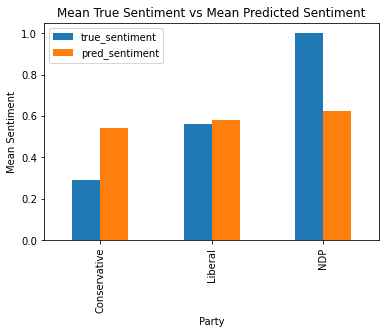

In [81]:
#plotting the mean true sentiment vs the mean predicted sentiment 
senti_results.plot(kind='bar', xlabel = 'Party', ylabel = 'Mean Sentiment', title = 'Mean True Sentiment vs Mean Predicted Sentiment')

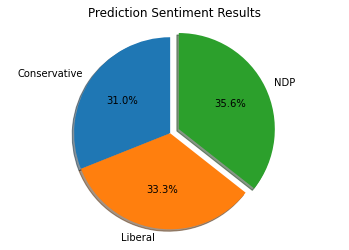

In [123]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Conservative', 'Liberal', 'NDP'
sizes = [31.03, 33.33, 35.60]
explode = (0, 0, 0.1)  # only "explode" the 3rd slice (i.e. 'NDP')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Prediction Sentiment Results')
plt.show()

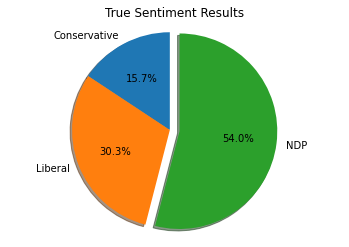

In [83]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Conservative', 'Liberal', 'NDP'
sizes = [15.7, 30.27, 54.0]
explode = (0, 0, 0.1)  # only "explode" the 3rd slice (i.e. 'NDP')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('True Sentiment Results')
plt.show()

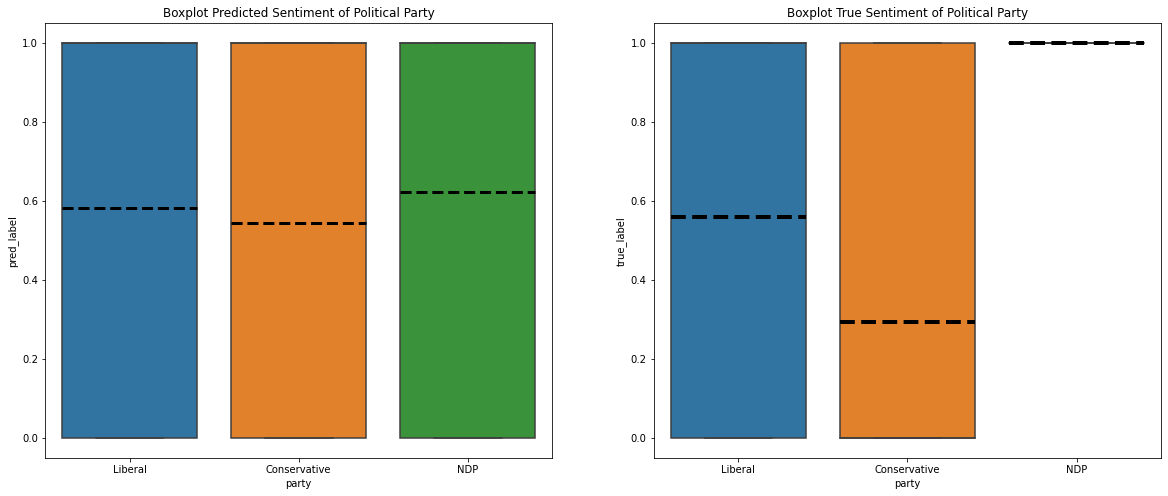

In [84]:
#creating boxplots of true and predicted sentiment of political parties
fig, axes = plt.subplots(1,2,figsize=(20,8))

#boxplot for predicted sentiment
sns.boxplot(x=party_results['party'], 
            y=party_results['pred_label'].astype('float'), 
            ax=axes[0], 
            showmeans=True, 
            meanline=True,
            meanprops=dict(linestyle='--', linewidth=3, color='black')).set_title('Boxplot Predicted Sentiment of Political Party') #sentiment line

#boxplot for true sentiment
sns.boxplot(x=party_results['party'], 
            y=party_results['true_label'].astype('float'), 
            ax=axes[1], 
            showmeans=True, 
            meanline=True,
            meanprops=dict(linestyle='--', linewidth=4, color='black')).set_title('Boxplot True Sentiment of Political Party') #sentiment line
plt.show()

Based on the mean true sentiment vs mean predicted sentiment graph it shows the following: 
- The true sentiment goes in this order: NDP, Liberal, Conservative
- The predicted sentiment goes in this order: NDP, Liberal, Conservative

You can better visually see the differene between the true and predicted sentiment for the political parties through the above boxplots. In the true sentiment boxplot you can notice that there is no coloured box for NDP that is because in the true sentiment  for NDP there were no negative tweets (hence why the sentiment is also at 1 as a whole). For the prediction sentiment NDP still has the most posiitve twitter sentiment but also has some negative ones (contrary to the true sentiment). 

Based off the actual 2019 Political campaign the election was in this order for votes: Liberal, Conservative, NDP. This being said, the true sentiment does not reflect the actual election results. However, the mean predicted sentiment follows the same order as the true sentiment order which means both the true sentiment and the prediction sentiment do not reflect the actual 2019 Canadian Election Results. This may be due to the selected word choices to group into the political parties (perhaps they were put into the wrong parties), minimal data and data cleaning steps. 

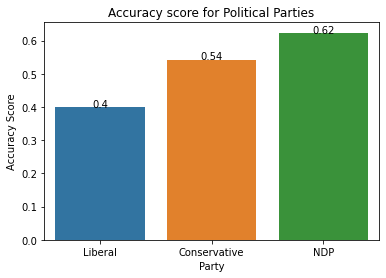

In [85]:
#creating plot to visualize the accuracy score for the 3 political parties

partiesx = ['Liberal', 'Conservative', 'NDP']
#creating dataframe of parties and accuracy scores
party_results = pd.DataFrame(
    {'party': partiesx,
     'accuracy_score': accscore
    })

#creating the plot
party_plot = sns.barplot(x= party_results['party'], y=party_results['accuracy_score'], data=party_results)

#setting the axis
party_plot.set_title("Accuracy score for Political Parties")
party_plot.set(xlabel = 'Party', ylabel = 'Accuracy Score')

#printing the accuracy scores above the bars
for index, row in party_results.iterrows():
    party_plot.text(row.name,row.accuracy_score, round(row.accuracy_score,2), color='black', ha="center")

The chart above shows that the NDP party tends to have the highest accuracy at 0.62. The conservative party has an accuracy score of 0.54 which is still better than a random guess but the Liberal accuracy is very low at 0.4 which is essentially saying the predictions for that party are not good. However, as mentioned earlier, all these graphs and analysis about the political parties are very dependent on how well the tweets were allocated to specific parties. If the allocation for tweets were incorrect than the rest of the results and predictions will be affected. What is meant by this is that, lets say we actually knew the party each person that tweeted those tweets was going to vote for and did this analysis, our results would obviously be better because we now have a relationship between the party and the tweets. However, in this analysis we did not know which tweet corresponds to which party, it was something we had to infer by labelling key words to each party. That is where the grey area is for NLP analytics based on twets is useful for political parties during election campaigns. My analysis is a good example of where it can go wrong...in my analysis you would assume that NDP would win the election because the accuracy score is high and they have the highest mean sentiment value indicating positive tweets towards them. However, this was clearly not the case in the 2019 election as the Liberals won with the conservatives being second in line. 

This all being said, i do believe that NLP analytics is still a good and useful tool for political parties during election campaigns as it is a good way for data scientists to atleast explore the results and notice trends in tweets and negative sentiment in tweets and the reason for the negative sentiments and perhaps act on those reasons. For example; if i was working for the liberal party and noticed that most of the negative tweets towards the liberal party were directed towards a scandal, it would be safe to reccommend that the liberal party should try to focus on addressing the scandal to decrease the negative sentiment towards it to potentially limit those negative tweets. More on this is mentioned in the next section. 

### Negative Canadian Election Tweets

Here we are going to create a multi-class classification model to predict the reason for negative tweets. I will be doing the following: 
1. label encoding the negative reason column 
2. train,test split 
3. bow feature encoding
4. Using 3 different classification models: Decision Tree Classification, Naive Bayes and SVM

The main reason for choosing these 3 classification models were based on computation time. In a real setting i understand that this should not be the only reason to choose to use a specific model but for assignment purposes and to limit server crashes this approach was taken. 

In [86]:
#filtering dataframe for only negative sentiment tweets
neg = df[df['sentiment'] == 'negative']

In [87]:
#Creating a table that shows the corresponding negative tweets based on each political party 
neg_party  = pd.crosstab(neg['negative_reason'], neg['actualparty'])
neg_party

actualparty,Conservative,Liberal,Other
negative_reason,,,
Climate Problem,23,15,3
Economy,25,22,4
Healthcare,3,1,1
Healthcare and Marijuana,4,0,0
Others,157,94,113
Privilege,4,5,3
Scandal,95,114,61
Separation,6,7,3
Tell lies,111,53,34


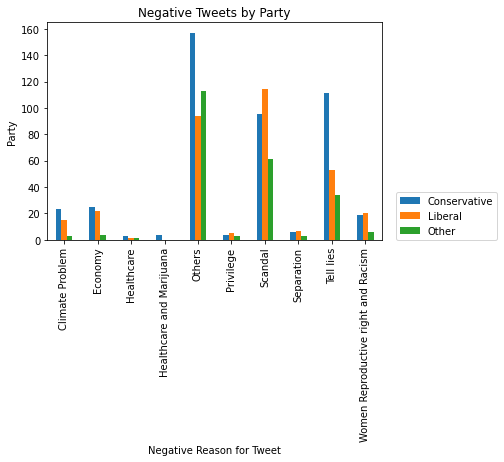

In [88]:
#plotting the results from the table to visually see why each party recieved negative sentiment
neg_party.plot(kind='bar', xlabel = 'Negative Reason for Tweet', ylabel = 'Party', title = 'Negative Tweets by Party')
plt.legend(loc=(1.04,0))

This graph shows the reasoning for the negative tweets for each political party. Certain inferences can be taken from this graph as such: 
- Most of the negative tweets towards liberals are due to a Scandal 
- Most of the negative tweets towards conservatives are due to 'Other' and telling lies 
- It can be noticed here that there is no bar for NDP, this is because NDP was considered to have no negative tweets earlier in the analysis section. Clearly, now looking at the graph, this was most likely not a good assumption to make, however since this graph is based on what a user would input as what they believe are words that would filter out for each party, it should be noted that this graph varies based on political party grouping. As mentioned earlier since the election is typically back and forth between the liberals and the conservatives, NDP was overlooked in this analysis. 

In [89]:
#determining all the different negative reasoning 
df['negative_reason'].unique()

array(['Women Reproductive right and Racism', nan, 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

Since the target variable is going to be the negative reason column we need to make it numerical. To do this i used label encoding and assigned each unique value to a number. I combined healthcare and healthcare and marijuana as they are very close to each other and are only one datapoint off based off the previous value_count done in the exploratory analsysis

In [90]:
#label encoding the negative reason column
neg_reason = {'Women Reproductive right and Racism': 0, 'Economy':1, 'Others':2,
       'Scandal':3, 'Tell lies':4, 'Privilege':5, 'Climate Problem':6,
       'Healthcare':7, 'Separation':8, 'Healthcare and Marijuana':7}
neg['negative_reason'] = neg['negative_reason'].map(neg_reason)

In [91]:
#assigning feature variables and target variable
X3 = neg['clean_tweets']
y3 = neg['negative_reason']

In [92]:
#splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.3, random_state=1)

##### Feature Encoding
Bag of words was used for this model because the previous model results (from the 14 models) the bow accuracy scores were slightly higher when a difference was seen. 

In [93]:
# Bag of Words feature encoding.
bow = CountVectorizer(max_features=1000).fit(X_train) # Number of features are limited to the top by term frequency.
bowx_train = bow.transform(X_train).toarray()
bowx_test = bow.transform(X_test).toarray()

#### Multi-class classification Models

First we are going to run the models without tuning and then with tuning and then compare the results. 

The same process will be used for all 3 models: 
- Run the original model and get accuracy score
- get_params to view the hyperparemters
- use grid search for hyperparameter tunning
- printout the best accuracy score and best parameters for each model

##### 1.1 Decision Tree Classification (pre-tuning)

In [94]:
#function for the original model
def DT(X_train, X_test, y_train, y_test):
    
    DT_model = DecisionTreeClassifier(random_state=1)
    DT_model.fit(X_train, y_train)
    predictions = DT_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    print(classification_report(y_test, predictions))
    
    return ACC

In [95]:
#running the original model and printing the accuracy score
DT_bow = DT(bowx_train, bowx_test, y_train, y_test)
print('Accuracy Score: %.5f' % (DT_bow))

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       0.60      0.18      0.27        17
           2       0.54      0.61      0.57       114
           3       0.48      0.46      0.47        83
           4       0.52      0.53      0.53        58
           5       0.00      0.00      0.00         2
           6       0.36      0.45      0.40        11
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         6

   micro avg       0.50      0.50      0.50       302
   macro avg       0.33      0.33      0.32       302
weighted avg       0.50      0.50      0.49       302

Accuracy Score: 0.50331


##### 1.2 Decision Tree Classification (tuning)

In [96]:
#viewing the default parameters
DecisionTreeClassifier().get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

In [97]:
#function that uses grid search to tune hyperparemeters and prints the best score and hyperparameters
def DTh(X_train, X_test, y_train, y_test):

    #running the model
    DT_model = DecisionTreeClassifier(random_state=1)
    # define evaluation
    cv = StratifiedKFold(n_splits=3, random_state=1)
    # define search space
    space = dict()
    space['max_depth'] = [5,10,15]
    space['min_samples_leaf'] = [1,3,5]
    # define search
    grid_search = GridSearchCV(DT_model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    # execute search
    result = grid_search.fit(X_train, y_train)
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    
    return result.best_score_, result.best_params_

In [98]:
#applying the Grid Search of hyperparameters on the model
DT_bow = DTh(bowx_train, bowx_test, y_train, y_test)

Best Score: 0.5298295454545454
Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 5}


In [99]:
#Tuned Model
DT_model_best = DecisionTreeClassifier(max_depth= 15, min_samples_leaf=5, random_state=1)

Summary of Decision Tree Classification Results: 
- Original Model accuracy score: 0.50331
- Tuned Model accuracy score: 0.52982

##### 2.1 Naive Bayes Classification (pre-tuning)

In [100]:
#function for the original model
def NB(X_train, X_test, y_train, y_test):

    NB_model = MultinomialNB()
    NB_model.fit(X_train, y_train)
    predictions = NB_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [101]:
#running the original model and printing the accuracy score
NB_bow = NB(bowx_train, bowx_test, y_train, y_test)
print('Accuracy Score: %.5f' % (NB_bow))

Accuracy Score: 0.50331


##### 2.2 Naive Bayes Classification (tuning)

In [102]:
#viewing the default parameters
MultinomialNB().get_params

<bound method BaseEstimator.get_params of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)>

In [103]:
#function that uses grid search to tune hyperparemeters and prints the best score and hyperparameters
def NBh(X_train, X_test, y_train, y_test):

    #running the model
    LR_model = MultinomialNB()
    # define evaluation
    cv = StratifiedKFold(n_splits=3 ,random_state=1)
    # define search space
    space = dict()
    space['alpha'] = [0,0.5,1]
    space['fit_prior'] = [True, False]
    # define search
    grid_search = GridSearchCV(LR_model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    # execute search
    result = grid_search.fit(X_train, y_train)
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    
    return result.best_score_, result.best_params_

In [104]:
#applying the Grid Search of hyperparameters on the model
NB_bow = NBh(bowx_train, bowx_test, y_train, y_test)

Best Score: 0.5255681818181818
Best Hyperparameters: {'alpha': 1, 'fit_prior': True}


In [105]:
#Tuned Model
NB_model_best = MultinomialNB(alpha=1, fit_prior= True)

Summary of Naive Bayes Classification Results: 
- Original Model accuracy score: 0.50331
- Tuned Model accuracy score: 0.52556

##### 3.1 Support Vector Machine/LinearSVC (pre-tuning)

In [106]:
#function for the original SVM model
def SVM(X_train, X_test, y_train, y_test):
    
    SVM_model = LinearSVC()
    SVM_model.fit(X_train, y_train)
    predictions = SVM_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [107]:
#running the original model and printing the accuracy score
SVM_bow = SVM(bowx_train, bowx_test, y_train, y_test)
print('Accuracy Score: %.5f' % (SVM_bow))

Accuracy Score: 0.49669


##### 3.2 Support Vector Machine/LinearSVC (tuning)

In [108]:
#viewing the default parameters
LinearSVC().get_params

<bound method BaseEstimator.get_params of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)>

In [109]:
#function that uses grid search to tune hyperparemeters and prints the best score and hyperparameters 
def SVMh(X_train, X_test, y_train, y_test):

    #running the model
    SVM_model = LinearSVC()
    # define evaluation
    cv = StratifiedKFold(n_splits=3 ,random_state=1)
    # define search space
    space = dict()
    space['max_iter'] = [100,1000,2000]
    space['C'] = [0.1,0.5,1]
    # define search
    grid_search = GridSearchCV(SVM_model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    # execute search
    result = grid_search.fit(X_train, y_train)
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    
    return result.best_score_, result.best_params_

In [110]:
#applying the Grid Search of hyperparameters on the model
SVM_bow = SVMh(bowx_train, bowx_test, y_train, y_test)

Best Score: 0.5198863636363636
Best Hyperparameters: {'C': 0.1, 'max_iter': 100}


In [111]:
#tuned SVM model
SVM_model_best = LinearSVC(C=0.1, max_iter= 100)

Summary of SVM Classification Results: 
- Original Model accuracy score: 0.49669
- Tuned Model accuracy score: 0.51988

#### Summary of tuning models

Based on the summary of each of the classification results it can be noted that all 3 of the models improved (even though it was only slighty) of their model accuracy. 

### Testing prediction reason for negative sentiment tweets
After comparing all 3 of the models (after hyperparameter tuning) they are ranked as below: 
1. DecisionTreeClassifier
2. MultinomialNB
3. LinearSVC

Therefore we will be using the DecisionTreeClassifier to test the prediction reason for negative sentiment tweets

In [112]:
#applying the best model to test the prediction for negative sentiment tweets and printing the accuracy score and classification report
DT_model_best = DecisionTreeClassifier(max_depth= 15, min_samples_leaf=5, random_state=1)
DT_model_best.fit(bowx_train, y_train)
predictions = DT_model_best.predict(bowx_test)

ACC = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))
print('Accuracy Score: %.5f' % (ACC))

              precision    recall  f1-score   support

           0       0.54      0.88      0.67         8
           1       0.60      0.18      0.27        17
           2       0.48      0.94      0.64       114
           3       0.82      0.33      0.47        83
           4       0.88      0.38      0.53        58
           5       0.00      0.00      0.00         2
           6       1.00      0.36      0.53        11
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         6

   micro avg       0.56      0.56      0.56       302
   macro avg       0.48      0.34      0.35       302
weighted avg       0.66      0.56      0.52       302

Accuracy Score: 0.56291


Aside from accuracy score the classification report is also a good indication on how well the modeling it doing. I ran the classification report for the model before tuning it and then after. Precision is a good measurement to tell you how precise our prediction of each class is. For example, one can note that in the pre tuned model the first class (0) had a score of 0.50 but now has a score of 0.54 so there has been an improvement in false allocations. Precision is essentially a eighted average of precision and recall. Therefore the f1-score is also a good metric to use when trying to increase accuracy and determine improvements. 

Overall, the accuracy was improved from 0.50 to 0.56!

#### Model Feature Importance

Model feature importance is important for predictive moedlling as it indicates the relative importance of each feature and assigns it a score. Below, using .feature_importance_ we are able to output the top 10 most important features for the model. A graph is a good visual to see the difference between the importance of the features as you can tell here which features have the most impact to your model. In this case, feature 'lie' has the most effect. 

The exact scores for the top 10 features can also be seen below.

In [168]:
#getting the feature importance from the decision tree model and then outputting a bar plot to represent the top 10 important features
feat_importances = pd.Series(DT_model_best.feature_importances_)

#getting the feature names
features = bow.get_feature_names()

#creating new dataframe with the feature names and feature scores
featureimportance = pd.DataFrame(
    {'feature': features,
     'feature_importance_score': feat_importances
    })
#setting the index to the actual feature names
feature_importance = featureimportance.set_index('feature')
#sorting the features by decsending to get the top 10 important features
feature_importance_df = feature_importance.sort_values(by = ['feature_importance_score'],ascending = False)

<AxesSubplot:title={'center':'Model Feature Importance for predicting Negative Canadian Election Tweets'}, ylabel='Feature'>

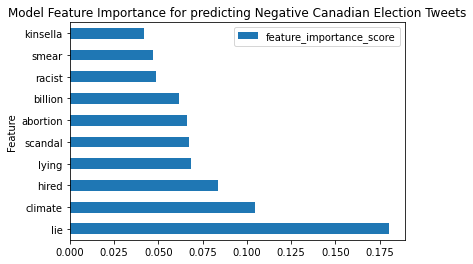

In [169]:
#plotting the feature importance
feature_importance_df.nlargest(10,columns = ['feature_importance_score']).plot(kind='barh', title = 'Model Feature Importance for predicting Negative Canadian Election Tweets', xlabel = 'Feature')

#### Comparing the True and Predicted Negative Tweets 

Comparing the true and predicted negative tweets can tell us why a tweet has a negative sentiment. This is an important variable to explore as in a political campaign the goal is to obviously get as many votes as possible. It is assumed that if a candidate knows why there is a negative sentiment towards them that they can easily try to fix that sentiment or work towards fixing it (similar to what was mentioned earlier when the model was being implemented). Therefore, having an accurate prediciton for negative tweets can be essential political parties during election campaigns. 

In [115]:
#creating a dataframe of the true and predicted negative reasons

#combining the true reasons and the predicted reasons
test_list = y_test.tolist()
pred_list = predictions.tolist()

results = pd.DataFrame(
    {'true_reason': test_list,'predicted_reason': pred_list})

#taking the value counts of each true reason and putting them into a sorted list
true = results.true_reason.value_counts()
true_sort = true.sort_index()
true_list = true_sort.tolist()

#taking the value counts of each predicted reason and putting them into a sorted list
pred = results.predicted_reason.value_counts()
pred_sort = pred.sort_index()
pred_list = pred_sort.tolist()

#adding 0 for label 5
midpoint = len(pred_list)//2+2
pred_list = pred_list[0:midpoint] + [0] + pred_list[midpoint:] 
#adding 0 for label 7
midpoint = len(pred_list)//2+4
pred_list = pred_list[0:midpoint] + [0] + pred_list[midpoint:]
#adding 0 for label 8
midpoint = len(pred_list)//2+5
pred_list = pred_list[0:midpoint] + [0] + pred_list[midpoint:] 

#negative reasons in order of sorted list
reasons = ['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare and Marijuana', 'Separation']

#creating a table of the true reasons with the predicted reasons 
all_results = pd.DataFrame(
    {'negative_reason': reasons,'true_reason': true_list,'predicted_reason': pred_list})

all_results

,negative_reason,true_reason,predicted_reason
0,Women Reproductive right and Racism,8,13
1,Economy,17,5
2,Others,114,222
3,Scandal,83,33
4,Tell lies,58,25
5,Privilege,2,0
6,Climate Problem,11,4
7,Healthcare and Marijuana,3,0
8,Separation,6,0


In [116]:
#assigning the negative_reason column to be the new index
all_results = all_results.set_index('negative_reason')

<AxesSubplot:title={'center':'True Negative Reasoning vs Predicted Negative Reasoning in Canadian Election Tweets'}, xlabel='Negative Reason', ylabel='Reasoning Count'>

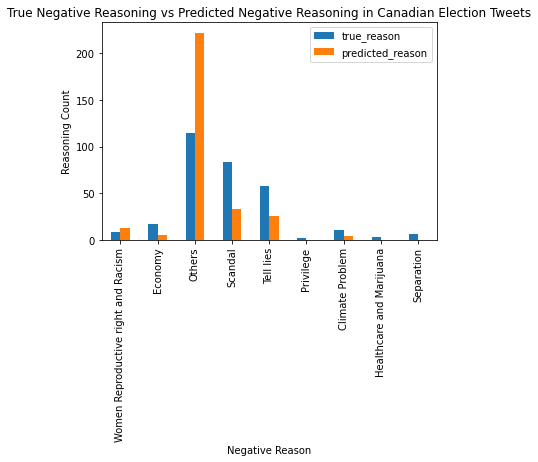

In [117]:
#plotting the reasoning count for the true and predicted negative reasoning tweets for comparison
all_results.plot(kind='bar', xlabel = 'Negative Reason', ylabel = 'Reasoning Count', title = 'True Negative Reasoning vs Predicted Negative Reasoning in Canadian Election Tweets')

Based the graph the order the true negative reasoning is: 
1. Other
2. Scandal
3. Tell lies
4. Economy
5. Climate Problem
6. Women Reproductive right and Racism
7. Separation
8. Healthcare and Marijuana 
9. Privilege

and the order of predicated negative reasoning is: 
1. Other
2. Scandal
3. Tell lies
4. Women Reproductive right and Racism
5. Economy
6. Climate Problem
7. no negative reasoning towards Separation, Healthcare and Marijuana and Privilege

Therefore, the predicted results followed the order from 1-3 but then changed. The predicted negative reasoning predicted more negative reasoning for women reporductive right and racism which caused a shift in the order. 

## Q5 Results
#### Research Question: "What can public opinion on Twitter tell us about the Canadian Political Landscape in 2019?"

Based on my analysis and results, public opinion on twitter essentially tells us that NDP will win the election. This was obviously not the case as Liberal was was the actual party to win. However, since i am basing everything off my results, that is what public opinion on twitter can tell us about the canadian political landscape in 2019. What public opinion can also tell us is that the reason people do not want to vote for the liberals is due to a scandal and people dont want to vote for conservatives because they tell lies (now both these negative reasonings have all the parties associated with them but these are the top parties of association). 

Public opinion can also tell us that more people that vote for Liberals tend to tweet about their opinions on the election as they were the most tweeted in this dataset. 

#### 5.2 Describe the results of the analysis and discuss your interpretation of the results
For this question the explanations can be seen throughout the notebook

#### 5.3 Explain how each party is viewed in the public eye based on the sentiment value

Below is how each party is viewed in the public eye based on the sentiment value: 

- Liberal :
For the liberal party, the public eye essentially feels negative feelings towards them majorly because of a scandal. The following top 4 reasons are:  Other, telling lies, Economy, Women Reproductive rights and racism, and Economy. 

- Conservative :
For the conservative party, the public eye feels negative feelings towards them majorly because of telling lies (it is actually 'Other' based on the analysis but since we dont know what falls under other the next highest is tell lies). The following top 3 reasons are: Scandal, Economy, and Climate problems. 

- NDP :
For the NDP party, the public eye feels mainly positive as they were the highest mean positive sentiment.

More explanation is given in the section regarding this above.

#### 5.4 For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets. 

The model that worked best was the Decision Tree Classifier. A few reasons why the model may have failed to predict the correct negative reason could to due to similarities of words associated with each negative reason (for example the same descriptive words for scandal and tell lies could be used). The training set is also very limited therefore more data would have been able to train a better model. Another reason i believe is also because of the distribution of the negative reasons. It is not evenly distributed so the higher the amount of data there is for a specific negative reason, the performance will be better for that negative reason.

For example, take a look at the table below for tweets that have a true negative reason of Economy. As you can see in the predicted column many of the tweets were predicted to be Other. The negative reason Economy had only 51 many value counts in the dataset, therefore that is not enough as opposed to 364 that was in Other for the model to be able to predict that reason. Therefore a more evenly distributed data for the negative reasons could potentially yeild better predictions. 

In [118]:
#to create the example for 54 i need to create a dataframe with the tested tweets, their true negative reason and predicted

#make test set into a list
tweets = X_test.tolist()

In [119]:
#reassigning pred_list to be the total predictions
pred_list = predictions.tolist()

In [120]:
#create dataframe with the combinations
example = pd.DataFrame(
    {'tweet': tweets,'true_reason': test_list,'predicted_reason': pred_list})

In [127]:
#replacing the sentiment back to the original sentiment values
neg_reasons = {0:'Women Reproductive right and Racism', 1:'Economy', 2:'Others',
       3:'Scandal', 4:'Tell lies', 5:'Privilege', 6:'Climate Problem',
       7:'Healthcare', 8:'Separation', 7:'Healthcare and Marijuana'}
example['true_reason'] = example['true_reason'].map(neg_reasons)
example['predicted_reason'] = example['predicted_reason'].map(neg_reasons)

In [121]:
#making it able to read the whole tweet
pd.set_option("display.max_colwidth", None)

In [129]:
#filtering for tweets that have the negative reason 1 (Economy)
example[example['true_reason'] == 'Economy']

,tweet,true_reason,predicted_reason
7,company sure come high cost party libs thousand fellow citizen community chooseforward cdnpoli quebec elxn,Economy,Others
12,would mr scheer asked thought harper decision cut gst good one cause b harper federal debt even policy cdnpoli elxn,Economy,Others
26,destroy canada industry trudeau canadian voting someone care nothing canada worker cdnpoli onpoli elxn trudeaumustgo scheerpm,Economy,Others
76,life even rich pay tax use care money pocket le quality life chooseforward voteliberal elxn elxn cdnpoli,Economy,Economy
86,trudeau photo reelected money cdn taxpayer global partner cdnpoli elxn,Economy,Others
87,canadian please informed vote future economy future child future planet stake vote strategically elxn cdnpoli,Economy,Others
96,nothing trudeau four year influence job claim making thing economy trudeau troll would cdnpoli elxn,Economy,Others
103,making life affordable elxn,Economy,Others
133,canada taxpayer hard dont need one many reason trudeaumustgo canada care snclavalinscandal election elxn cdnpoli,Economy,Others
175,problem record fund pay program thats view thats view old nice guy thought elxn itsourvote cdnpoli,Economy,Economy


In [141]:
#create dataframe with the combinations
results_viz = pd.DataFrame(
    {'tweet': tweets,'true_reason': test_list,'predicted_reason': pred_list})

[Text(-1.0, 0, ''),
 Text(0.0, 0, 'Women Reproductive right and Racism'),
 Text(1.0, 0, 'Economy'),
 Text(2.0, 0, 'Others'),
 Text(3.0, 0, 'Scandal'),
 Text(4.0, 0, 'Tell lies'),
 Text(5.0, 0, 'Privilege'),
 Text(6.0, 0, 'Climate Problem'),
 Text(7.0, 0, 'Healthcare and Maijuana'),
 Text(8.0, 0, 'Separation'),
 Text(9.0, 0, '')]

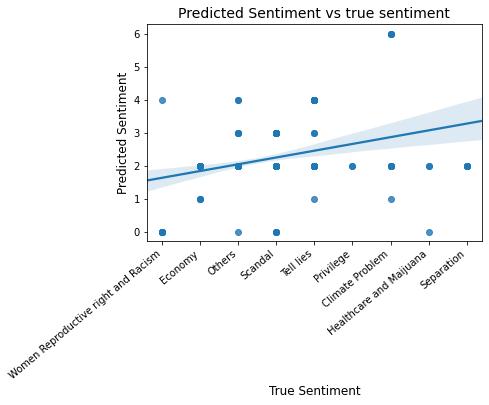

In [151]:
#visualization of results
ay = sns.regplot(x="true_reason", y="predicted_reason", data=results_viz)
font_size=12
label_size=9
ay.axes.set_title('Predicted Sentiment vs true sentiment',fontsize=font_size+2);
ay.set_xlabel('True Sentiment',fontsize=font_size);
ay.set_ylabel('Predicted Sentiment',fontsize=font_size);
ay.set_xticklabels(['','Women Reproductive right and Racism','Economy','Others','Scandal','Tell lies','Privilege','Climate Problem','Healthcare and Maijuana', 'Separation'])
ay.set_xticklabels(ay.get_xticklabels(), rotation=40, ha="right")

#### 5.5 For both models, suggest one way you can improve the accuracy of your models

One way the first model could improve accuracy is by limiting overfitting to the training set. This can be done through cross validation, better feature selection, and even the use of n-grams would have been beneficial. I believe a big reason as to why the model was overfitting was due to the steps done in data cleaning, I believe too many words (potential features) were removed and were left with words that were geared too much towards the generic tweet dataset.  

One way the second model could improve accuracy is to have more distributed negative reasoning data as well as using more advanced methods such as deep learning and word-embedding. I also used a Decision tree classifier (as it was the best one out of the 3 i ran) however, as mentioned in the model implementation section, decision tree classifiers are prone to overfitting so this also encourages the use of more advanced methods for improved accuracy. 

In general, to determine which model to use i looked mainly just at the accuracy score. I recognize that this is not the best score to look at when trying to pick the best model. Other metrics such as mean absolute error, explained variance and R2 score should also be considered. 